In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import SequentialPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def sequential_trial(dP, ramp=1, threshold=0.4, relative=1, perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.5, nNeurons=500, legend=True, name="sequential"):

    inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
    for t in range(trial):
        inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
    inputs.create(dP=dP)
    # print(inputs.Ps, inputs.sampled)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 2*max_cues*dt_sample:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0
    cues = min(int(RT/dt_sample)+1, 2*max_cues)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Evidence {a}") 
    for a in range(2):
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


RT 12.001, cues 24, choice 1, correct 1


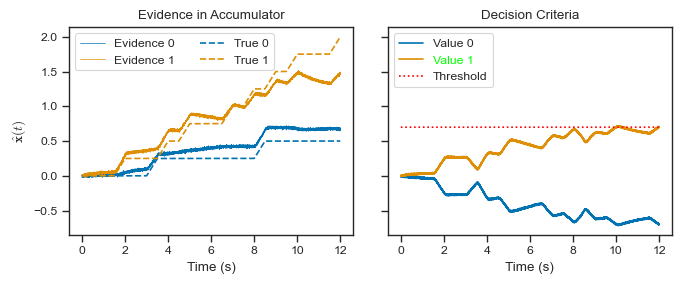

In [45]:
sequential_trial(dP=0.4, ramp=0.5, threshold=0.7, dt_sample=0.5)

RT 1.373, cues 14, choice 1, correct 1


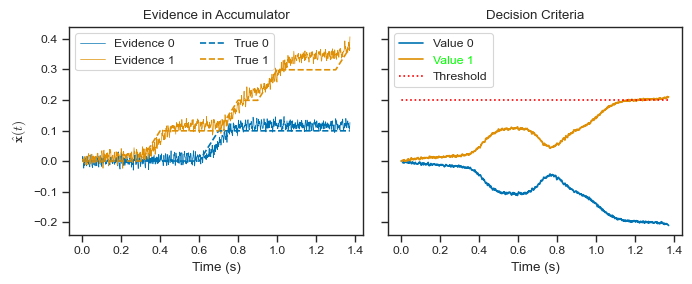

In [46]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, dt_sample=0.1)

RT 2.4010000000000002, cues 24, choice 0, correct 0


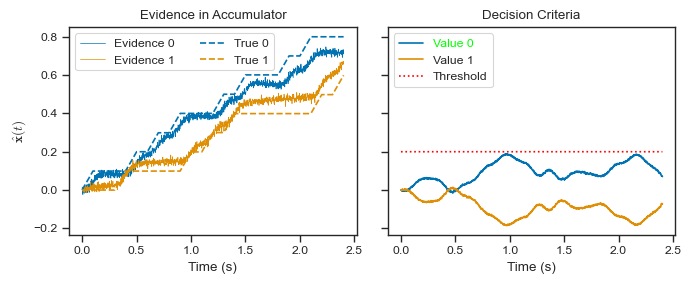

In [47]:
sequential_trial(dP=0.1, ramp=1, threshold=0.2)

RT 2.4010000000000002, cues 24, choice 1, correct 0


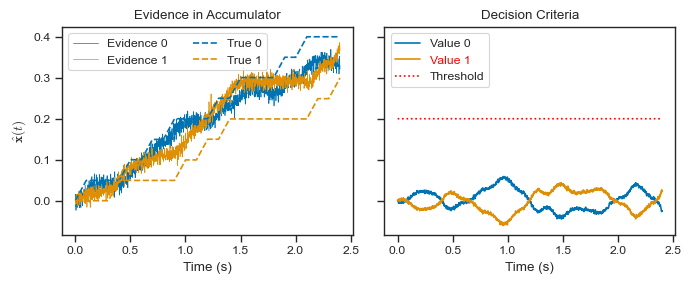

In [48]:
sequential_trial(dP=0.1, ramp=0.5, threshold=0.2)

RT 2.4010000000000002, cues 24, choice 0, correct 0


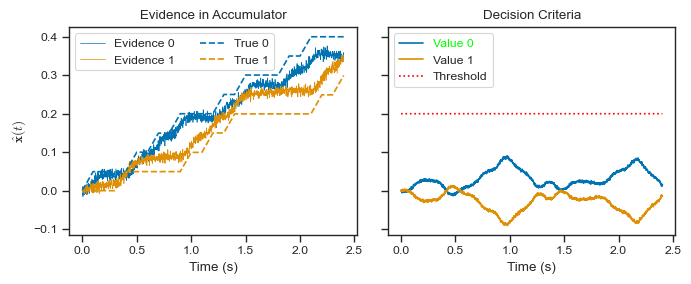

In [49]:
sequential_trial(dP=0.1, ramp=0.5, threshold=0.2, rA=1.0)

RT 2.4010000000000002, cues 24, choice 0, correct 0


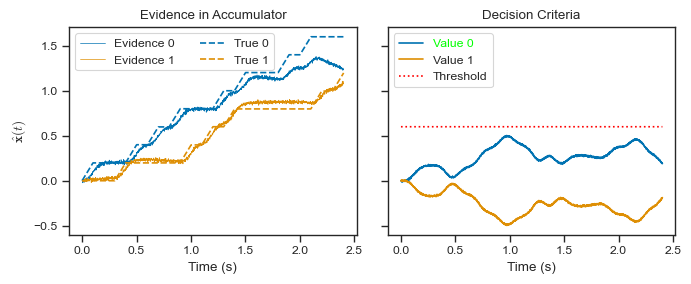

In [51]:
sequential_trial(dP=0.1, ramp=2.0, threshold=0.6, rA=1.5)

RT 0.994, cues 10, choice 0, correct 0


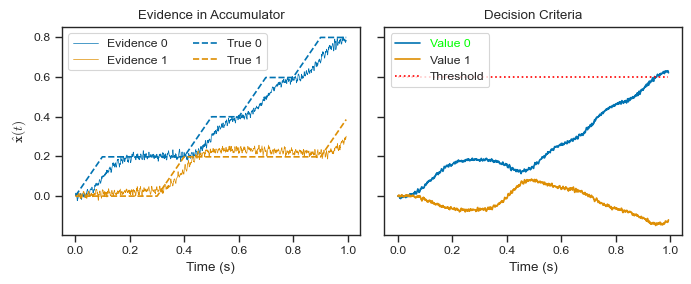

In [52]:
sequential_trial(dP=0.1, ramp=2.0, threshold=0.6, relative=0.5)

RT 2.4010000000000002, cues 24, choice 1, correct 0


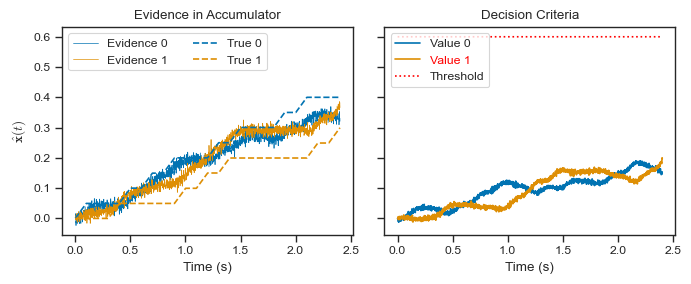

In [53]:
sequential_trial(dP=0.1, ramp=0.5, threshold=0.6, relative=0.5)

RT 2.142, cues 22, choice 0, correct 0


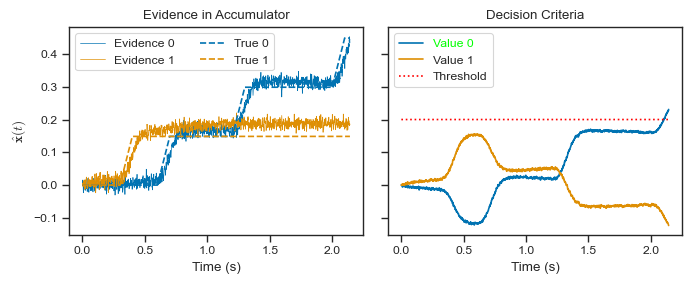

In [62]:
sequential_trial(dP=0.2, ramp=1.5, threshold=0.2, relative=0.8)

In [3]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical, max_cues, cue_step):
    bins = np.arange(0.0, 2*max_cues+cue_step, cue_step)
    cues_sim = simulated['cues'].to_numpy()
    cues_emp = empirical['cues'].to_numpy()
    hist_cues_sim = np.histogram(cues_sim, bins=bins)[0]
    hist_cues_emp = np.histogram(cues_emp, bins=bins)[0]
    normed_hist_cues_sim = hist_cues_sim / len(cues_sim)
    normed_hist_cues_emp = hist_cues_emp / len(cues_emp)
    loss = chi_squared_distance(normed_hist_cues_sim, normed_hist_cues_emp)
    print(f"loss {loss}")
    return loss

def compare_accuracy(simfile, pid, max_cues=12):
    pidstr = str(pid)
    emp = pd.read_pickle("data/fiedler2021.pkl").query(f"max_cues==@max_cues & id==@pidstr")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    for dP in [0.4, 0.2, 0.1]:
        emp_mean = emp.query("dP==@dP")['accuracy'].mean()
        sim_mean = sim.query("dP==@dP")['accuracy'].mean()
        print(f"dP {dP}, emp mean {emp_mean}, sim_mean {sim_mean}")

In [8]:
def simulate(dPs=[0.4, 0.2, 0.1], ramp=1.0, threshold=0.5, relative=1, perception_seed=0, pid=0,
                 rA=1.5, nNeurons=500, experiment_time=240, dt=0.001, max_cues=12, cue_step=4, dt_sample=0.1, name="fiedler_default", load=False):

    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    if not load:
        dfs = []
        columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues')
        for dP in dPs:
            inputs = SequentialPerception(seed=perception_seed+int(dP*10), dt_sample=dt_sample, max_cues=max_cues)
            total_time = 0
            trial = 0
            while total_time < experiment_time:
                inputs.create(dP=dP)
                # net = build_network(inputs, seed=pid, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative)
                net = build_network(inputs, seed=trial, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative, rA=rA)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > 2*max_cues*dt_sample:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                cues = min(int(RT/dt_sample)+1, 2*max_cues)
                print(f"trial {trial}, dP {dP}, elapsed time {total_time}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
                dfs.append(pd.DataFrame([['model', id, dP, trial, 100*correct, cues, max_cues]], columns=columns))
                total_time += RT
                trial += 1
        # print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle(f"data/{name}.pkl")
    else:
        sim = pd.read_pickle(f"data/{name}.pkl")

    pidstr = str(pid)
    emp = pd.read_pickle("data/fiedler2021.pkl").query(f"max_cues==@max_cues & id==@pidstr")
    data = pd.concat([sim, emp], ignore_index=True)
    for dP in dPs:
        loss = get_loss(data.query("type=='model' & dP==@dP"), data.query("type=='human' & dP==@dP"), max_cues, cue_step)
        print(f"dP {dP}, loss {loss}")

    fig = sns.FacetGrid(data, col="dP", col_order=[0.4, 0.2, 0.1], hue='type', palette=palette[:2], height=1.5, aspect=1.5)  # row="type",
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.set(xticks=bins)
    fig.add_legend()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 11, choice 1, correct 1
trial 1, dP 0.4, elapsed time 1.0130000000000001, cues 4, choice 0, correct 0
trial 2, dP 0.4, elapsed time 1.3840000000000001, cues 17, choice 0, correct 0
trial 3, dP 0.4, elapsed time 2.997, cues 14, choice 1, correct 1
trial 4, dP 0.4, elapsed time 4.313, cues 10, choice 0, correct 0
trial 5, dP 0.4, elapsed time 5.2379999999999995, cues 6, choice 0, correct 0
trial 6, dP 0.4, elapsed time 5.784, cues 5, choice 1, correct 1
trial 7, dP 0.4, elapsed time 6.2749999999999995, cues 15, choice 0, correct 0
trial 8, dP 0.4, elapsed time 7.6819999999999995, cues 11, choice 1, correct 1
trial 9, dP 0.4, elapsed time 8.764, cues 12, choice 0, correct 0
trial 10, dP 0.4, elapsed time 9.93, cues 14, choice 0, correct 0
trial 11, dP 0.4, elapsed time 11.265, cues 6, choice 0, correct 0
trial 12, dP 0.4, elapsed time 11.778, cues 6, choice 0, correct 0
trial 13, dP 0.4, elapsed time 12.334, cues 14, choice 0, correct 0
trial 14, dP 0

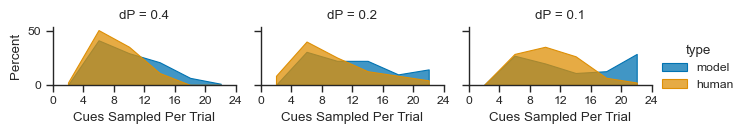

In [7]:
pid = 2
time = 240
ramp = 1.5
relative = 0.9
threshold = 0.2
name = "fiedler_test"
load = False

simulate(experiment_time=time, ramp=ramp, relative=relative, threshold=threshold, pid=pid, name=name, load=load)
compare_accuracy(name, pid)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 10, choice 1, correct 1
trial 1, dP 0.4, elapsed time 0.985, cues 4, choice 0, correct 0
trial 2, dP 0.4, elapsed time 1.342, cues 16, choice 0, correct 0
trial 3, dP 0.4, elapsed time 2.856, cues 14, choice 1, correct 1
trial 4, dP 0.4, elapsed time 4.239, cues 10, choice 0, correct 0
trial 5, dP 0.4, elapsed time 5.17, cues 6, choice 0, correct 0
trial 6, dP 0.4, elapsed time 5.737, cues 5, choice 1, correct 1
trial 7, dP 0.4, elapsed time 6.198, cues 14, choice 0, correct 0
trial 8, dP 0.4, elapsed time 7.587000000000001, cues 11, choice 1, correct 1
trial 9, dP 0.4, elapsed time 8.604000000000001, cues 12, choice 0, correct 0
trial 10, dP 0.4, elapsed time 9.739, cues 14, choice 0, correct 0
trial 11, dP 0.4, elapsed time 11.055000000000001, cues 6, choice 0, correct 0
trial 12, dP 0.4, elapsed time 11.623000000000001, cues 6, choice 0, correct 0
trial 13, dP 0.4, elapsed time 12.193000000000001, cues 9, choice 0, correct 0
trial 14, dP 0.4, el

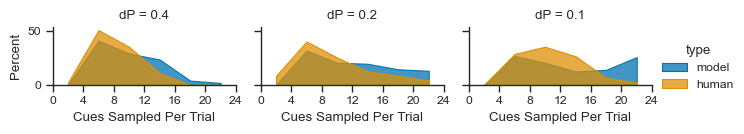

In [9]:
pid = 2
time = 240
ramp = 1.5
relative = 0.9
threshold = 0.2
name = "fiedler_test"
load = False
nNeurons = 1000

simulate(nNeurons=nNeurons, experiment_time=time, ramp=ramp, relative=relative, threshold=threshold, pid=pid, name=name, load=load)
compare_accuracy(name, pid)

loss 0.03671747544335656
dP 0.4, loss 0.03671747544335656
loss 0.16216171306832539
dP 0.2, loss 0.16216171306832539
loss 0.15283117839203317
dP 0.1, loss 0.15283117839203317
dP 0.4, emp mean 93.33333333333333, sim_mean 98.83720930232558
dP 0.2, emp mean 93.61702127659575, sim_mean 90.69767441860465
dP 0.1, emp mean 73.33333333333333, sim_mean 66.66666666666667


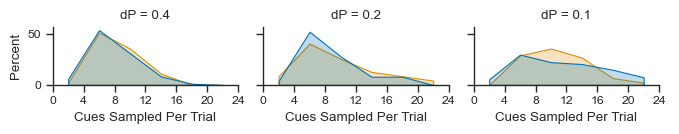

In [42]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.38, relative=0.83, threshold=0.48, pid=2, max_cues=12, name="scan_dP_2", load=True)
compare_accuracy("scan_dP_2", max_cues=12, pid=2)

loss 0.037010268886117345
dP 0.4, loss 0.037010268886117345
loss 0.517380987544922
dP 0.2, loss 0.517380987544922
loss 0.5904907056888822
dP 0.1, loss 0.5904907056888822


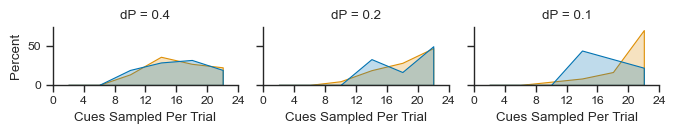

In [35]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.29, relative=0.81, threshold=0.85, pid=44, max_cues=12, name='nov23a_44', load=True)

loss 0.10090311227922588
dP 0.4, loss 0.10090311227922588
loss 0.5119939587290122
dP 0.2, loss 0.5119939587290122
loss 0.44763247538392714
dP 0.1, loss 0.44763247538392714


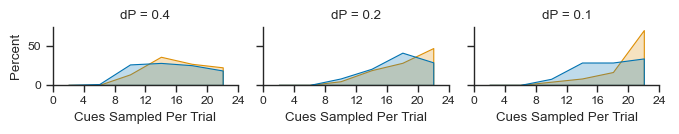

In [37]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*20, ramp=0.29, relative=0.81, threshold=0.85, pid=44, max_cues=12, name='pid44_long_44', load=True)

loss 0.037877883606657156
dP 0.4, loss 0.037877883606657156
loss 0.752241503976862
dP 0.2, loss 0.752241503976862
loss 0.40923187088600627
dP 0.1, loss 0.40923187088600627


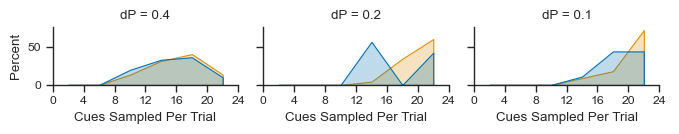

In [39]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.31, relative=0.81, threshold=0.92, pid=9, max_cues=12, name='nov24a_9', load=True)

loss 0.1102446603414523
dP 0.4, loss 0.1102446603414523
loss 0.7088263314829868
dP 0.2, loss 0.7088263314829868
loss 0.46703567165256754
dP 0.1, loss 0.46703567165256754


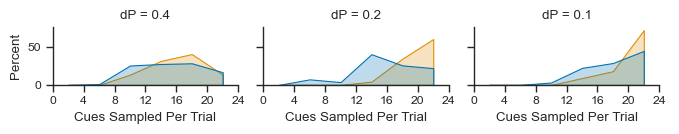

In [41]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*20, ramp=0.31, relative=0.81, threshold=0.92, pid=9, max_cues=12, name='pid9_long_9', load=True)

loss 0.4956698792576655
dP 0.4, loss 0.4956698792576655
loss 1.0
dP 0.2, loss 1.0
loss 0.17531426754544746
dP 0.1, loss 0.17531426754544746


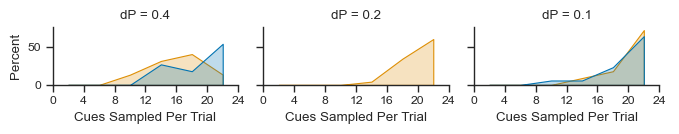

In [46]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.31, relative=0.0, threshold=0.92, pid=9, max_cues=12, name='9_hard_nov25a', load=True)

loss 0.5700137266511581
dP 0.4, loss 0.5700137266511581
loss 1.0
dP 0.2, loss 1.0
loss 0.43378810717020533
dP 0.1, loss 0.43378810717020533


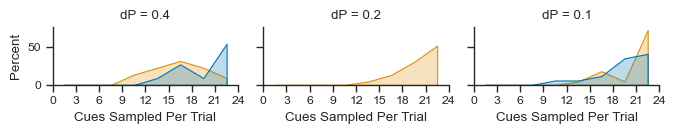

In [45]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.31, relative=0.0, threshold=0.92, pid=9, max_cues=12, cue_step=3, name='9_hard_nov25a', load=True)

loss 0.39808827821500437
dP 0.4, loss 0.39808827821500437
loss 0.09243930568329463
dP 0.2, loss 0.09243930568329463
loss 0.131875
dP 0.1, loss 0.131875
dP 0.4, emp mean 100.0, sim_mean 100.0
dP 0.2, emp mean 95.23809523809524, sim_mean 87.87878787878788
dP 0.1, emp mean 95.83333333333333, sim_mean 65.625


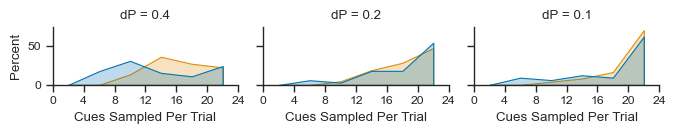

In [55]:
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.36, relative=0.98, threshold=0.79, pid=44, name='44_normal_nov25b', nNeurons=500, rA=2.0, load=True)
compare_accuracy("44_normal_nov25b", max_cues=12, pid=44)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, dP 0.4, elapsed time 0, cues 9
trial 1, dP 0.4, elapsed time 4.29, cues 20
trial 2, dP 0.4, elapsed time 13.971, cues 12
trial 3, dP 0.4, elapsed time 19.584, cues 6
trial 4, dP 0.4, elapsed time 22.356, cues 8
trial 5, dP 0.4, elapsed time 26.124000000000002, cues 11
trial 6, dP 0.4, elapsed time 31.611000000000004, cues 11
trial 7, dP 0.4, elapsed time 36.987, cues 12
trial 8, dP 0.4, elapsed time 42.96, cues 12
trial 9, dP 0.4, elapsed time 48.9, cues 9
trial 10, dP 0.4, elapsed time 52.935, cues 24
trial 11, dP 0.4, elapsed time 64.936, cues 24
trial 12, dP 0.4, elapsed time 76.93700000000001, cues 24
trial 13, dP 0.4, elapsed time 88.93800000000002, cues 12
trial 14, dP 0.4, elapsed time 94.52500000000002, cues 8
trial 15, dP 0.4, elapsed time 98.49400000000001, cues 24
trial 16, dP 0.4, elapsed time 110.49500000000002, cues 10
trial 17, dP 0.4, elapsed time 115.39100000000002, cues 17
trial 18, dP 0.4, elapsed time 123.85700000000001, cues 18
trial 19, dP 0.4, elapsed ti

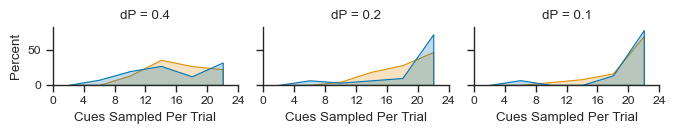

In [57]:
name = "44_all_nov26a"
scan_dP(dPs=[0.4, 0.2, 0.1], experiment_time=60.0*5, ramp=0.39, relative=0.97, threshold=0.93, pid=44, name=name, nNeurons=500, rA=3.0, load=False)
compare_accuracy(name, max_cues=12, pid=44)

# Empirical

In [40]:
def remake_fiedler():
    emp = pd.read_pickle("data/empirical.pkl")
    dfs = []
    columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues')
    for i, pid in enumerate(emp['participant_id'].unique()):
        for dP in [0.4, 0.2, 0.1]:
            # print(f"pid {pid}, dP {dP}")
            subdata = emp.query("participant_id==@pid & delta==@dP")
            trial = 0
            for index, row in subdata.iterrows():
                dfs.append(pd.DataFrame([["human", f"{i}", dP, trial, 100*row['correct'], row['cues'], row['maxSamples']]], columns=columns))
                trial += 1
    df = pd.concat(dfs, ignore_index=True)
    df.to_pickle("data/fiedler2021.pkl")

In [41]:
remake_fiedler()

In [19]:
def condense_fiedler():
    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021.pkl")
    for pid in emp['id'].unique():
        for dP in [0.4, 0.2, 0.1]:
            subdata = emp.query("id==@pid & dP==@dP")
            mean_cues = subdata['cues'].mean()
            var_cues = subdata['cues'].std()
            mean_acc = subdata['accuracy'].mean()
            var_acc = subdata['accuracy'].std()
            dfs.append(pd.DataFrame([['human', pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_emp = pd.concat(dfs, ignore_index=True)
    new_emp.to_pickle("data/fiedler2021_condensed.pkl")

In [20]:
def plot_condensed():
    new_emp = read_pickle("data/fiedler2021_condensed.pkl")
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((7,2)))
    for i, dP in enumerate([0.4, 0.2, 0.1]):
        subdata = new_emp.query("dP==@dP")
        x = subdata['mean cues'].to_numpy()
        y = subdata['mean acc'].to_numpy()
        xerr = subdata['var cues'].to_numpy()
        yerr = subdata['var acc'].to_numpy()
        axes[i].errorbar(x, y, xerr=xerr, yerr=0*yerr, fmt="o")
    plt.tight_layout()

    fig = sns.FacetGrid(new_emp, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/facet2.svg")
    fig.savefig(f"plots/facet2.png", dpi=600)

In [21]:
def plot_emp_RTs(max_cues, cue_step):
    emp = pd.read_pickle("data/fiedler2021.pkl").query("max_cues==@max_cues")
    fig = sns.FacetGrid(emp, row="id", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.svg")
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.png", dpi=600)

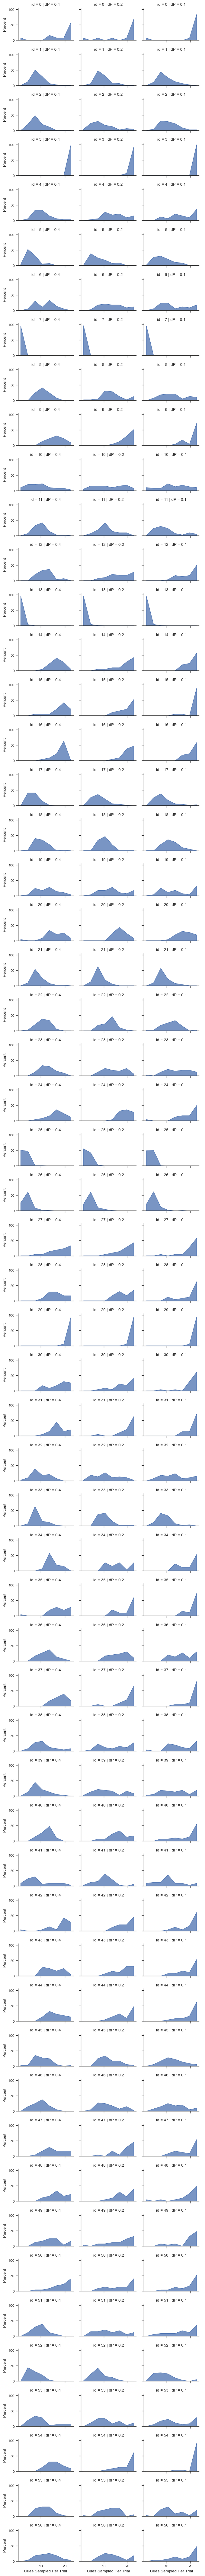

In [22]:
plot_emp_RTs(max_cues=12, cue_step=3)

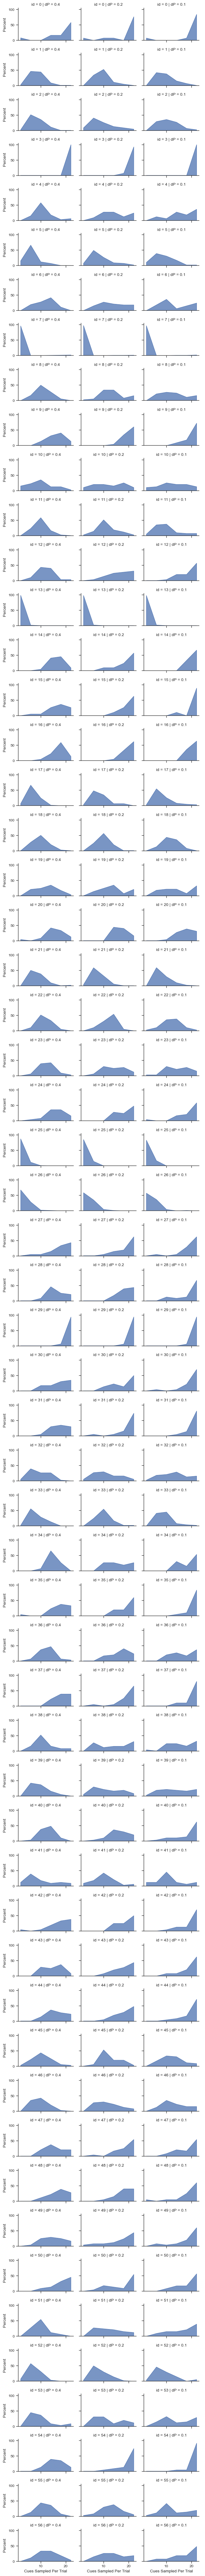

In [11]:
plot_emp_RTs(max_cues=12, cue_step=4)

In [120]:
def agent_population(nAgents, dPs=[0.4, 0.2, 0.1], ramps=[0.2, 0.4], thresholds=[0.8, 1.0], relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="agent_population", load=False):

    rng = np.random.RandomState(seed=perception_seed)
    if not load:
        dfs = []
        for agent in range(nAgents):
            ramp = rng.uniform(ramps[0], ramps[1])
            threshold = rng.uniform(thresholds[0], thresholds[1])
            inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
            columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
            for dP in dPs:
                inputs.create(dP=dP)
                total_time = 0
                trial = 0
                while total_time < experiment_time:
                    print(f"trial {trial}, dP {dP}, agent {agent}")
                    net = build_network(inputs, seed=agent, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > cues_max*dt_sample:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    cues = int(RT/dt_sample)+1
                    dfs.append(pd.DataFrame([['model', agent, dP, trial, 100*correct, cues]], columns=columns))
                    total_time += RT
                    trial += 1
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle("data/agent_population.pkl")
    else:
        sim = pd.read_pickle("data/agent_population.pkl")

    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021_new.pkl")
    combined = pd.concat([sim, emp], ignore_index=True)    
    for type in ['model', 'human']:
        for pid in combined.query("type==@type")['id'].unique():
            for dP in [0.4, 0.2, 0.1]:
                subdata = combined.query("id==@pid & dP==@dP")
                mean_cues = subdata['cues'].mean()
                var_cues = subdata['cues'].std()
                mean_acc = subdata['accuracy'].mean()
                var_acc = subdata['accuracy'].std()
                dfs.append(pd.DataFrame([[type, pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_combined = pd.concat(dfs, ignore_index=True)
    new_combined.to_pickle("data/population_combined.pkl")

    fig = sns.FacetGrid(new_combined, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/population_combined.svg")
    fig.savefig(f"plots/population_combined.png", dpi=600)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 18, dP 0.4, agent 0
trial 19, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 14, dP 0.2, agent 0
trial 15, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, 

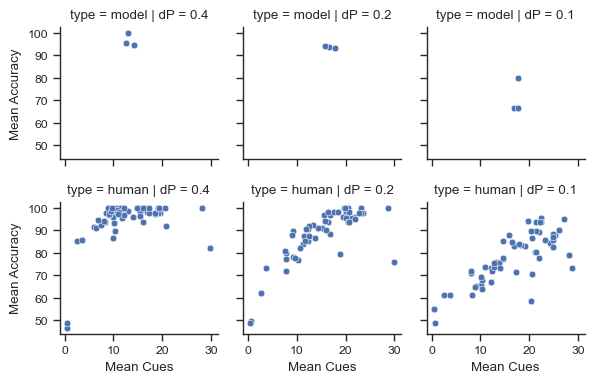

In [121]:
agent_population(nAgents=3, experiment_time=120, load=False)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, dP 0.1, agent 0
trial 4, dP 0.1, agent 0
trial 5, dP 0.1, agent 0
trial 6, dP 0.1, agent 0
trial 7, dP 0

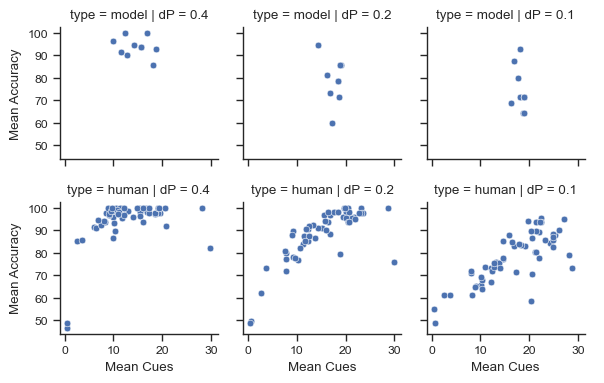

In [123]:
agent_population(nAgents=10, experiment_time=120, load=False, thresholds=[0.6, 1.2], ramps=[0.2, 0.4])